# Spherical Painting Methods — Fast HEALPix particle painting in JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/REPLACE_ME/REPO/blob/main/07-Spherical_Painting_Methods.ipynb)
<!-- Replace the link above with your repo path -->

This notebook builds HEALPix sky maps from a 3D particle field by “painting” a spherical shell of particles onto the sphere.  
We compare several painting schemes implemented in JAX, measure their speed/accuracy, and confront the resulting angular power spectra with Limber-theory predictions.

**What you’ll do**
- Generate an LPT particle realization, select a radial shell, and bin to HEALPix maps.
- Compare painting methods: **NGP**, **Bilinear**, and **RBF-neighbor**, plus “paint high → `ud_grade` down” variants.
- Form overdensity maps, compute \(C_\ell\) up to \( \ell_{\max}=3\,\text{nside} \), and apply pixel-window corrections.


## Environment Setup and Imports

In [ ]:
# Environment setup for CPU-only execution
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

import jax

print("JAX backend:", jax.default_backend())
print("JAX version:", jax.__version__)

# Core imports
import numpy as np
import jax
import jax.numpy as jnp
import healpy as hp
import jax_healpy as jhp
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# JaxPM imports - including LPT functionality  
from jaxpm.spherical import paint_particles_spherical
import jax_cosmo as jc
from jaxpm.pm import linear_field, lpt
from jaxpm.painting import cic_paint_dx

# Set random seed for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# Plotting configuration
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12


JAX backend: cpu
JAX version: 0.7.2


## Simulation parameters

This cell defines the geometry, resolution, and cosmology for the mock—plus the spherical shell we’ll paint to the sky.

**Box & mesh**
- `box_size = (1000, 1000, 1000)` — cubic volume in $\mathrm{Mpc}/h$.
- `mesh_shape = (256, 256, 256)` — particles sampled on a $256^3$ mesh.  
  Total particles: $n_{\mathrm{particles}} = 256^3 = 16{,}777{,}216$.

**Angular resolution (HEALPix)**
- `nside = 256` → $N_{\mathrm{pix}} = 12\,\mathrm{nside}^2 = 786{,}432$ sky pixels.
- `paint_nside = 512` — optional “paint high → downsample” path to reduce aliasing.

**Observer & radial shell**
- `observer_position = (500, 500, 500)` in $\mathrm{Mpc}/h$ — center of the box.
- Radial shell: $R \in [R_{\mathrm{min}}, R_{\mathrm{max}}] = [150, 400]~\mathrm{Mpc}/h$.  
  The shell midpoint $R_{\mathrm{center}} = \frac{R_{\mathrm{min}} + R_{\mathrm{max}}}{2}$ sets the representative scale factor
  $a_{\mathrm{center}} = a(\chi = R_{\mathrm{center}})$ used for growth/painting bookkeeping.


In [43]:
# Simulation parameters
box_size = (1000.0, 1000.0, 1000.0)  # Physical box size [Mpc/h]
mesh_shape = (256, 256, 256)         # Particle mesh resolution (smaller for faster demo)
nside = 256                        # HEALPix resolution
n_particles = np.prod(mesh_shape) # Total particles
omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

# Observer and distance shell parameters
observer_position = np.array([500.0, 500.0, 500.0])  # Observer at box center
R_min = 150.0   # Minimum comoving distance [Mpc/h]
R_max = 400.0   # Maximum comoving distance [Mpc/h]
R_center = (R_min + R_max) / 2
a_center = jc.background.a_of_chi(cosmo, R_center).squeeze()
# High-resolution painting parameters
paint_nside = 512   # Paint at higher resolution, then downsample
scale_factor = a_center

print(f"Simulation Configuration:")
print(f"  Particles: {n_particles:,} ({mesh_shape[0]}³)")
print(f"  Box size: {box_size} Mpc/h")
print(f"  HEALPix nside: {nside} ({hp.nside2npix(nside):,} pixels)")
print(f"  High-res nside: {paint_nside} ({hp.nside2npix(paint_nside):,} pixels)")
print(f"  Distance shell: [{R_min:.1f}, {R_max:.1f}] Mpc/h")
print(f"  Observer position: {observer_position} Mpc/h")
print(f"  Scale factor at shell center: a = {scale_factor:.3f}")

Simulation Configuration:
  Particles: 16,777,216 (256³)
  Box size: (1000.0, 1000.0, 1000.0) Mpc/h
  HEALPix nside: 256 (786,432 pixels)
  High-res nside: 512 (3,145,728 pixels)
  Distance shell: [150.0, 400.0] Mpc/h
  Observer position: [500. 500. 500.] Mpc/h
  Scale factor at shell center: a = 0.914


## Generate LPT particle field

To create a 3D particle field for painting, we run a 2LPT setup: build $P(k)$ from `jc.Planck15`, draw a Gaussian linear field, compute displacements at scale factor $a$, and displace a $256^3$ grid.


In [53]:
def generate_lpt_particles(omega_c, sigma8, scale_factor=0.1):
    """Generate particle positions using 2nd order Lagrangian Perturbation Theory."""
    
    # Create cosmology and power spectrum function
    k = jnp.logspace(-4, 1, 128)  # k range for power spectrum
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Generate initial conditions (density field)
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=key)
    
    # Create initial particle grid positions
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape], indexing="ij"), axis=-1)

    # Apply 2nd order LPT to get displacements
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, a=scale_factor, order=1)
    
    # Return displaced particle positions
    lpt_positions = particles + dx
    lpt_field = cic_paint_dx(dx)

    return lpt_positions, initial_conditions, lpt_field

# Generate LPT-based particle distribution
print("Generating First Order LPT Particle Distribution...")
print("Using cosmological parameters: Ωc = 0.25, σ8 = 0.8, a = 0.1")

positions_default, initial_density_field, lpt_field = generate_lpt_particles(omega_c, sigma8, scale_factor)

# Count particles in distance shell
positions_phys = positions_default * jnp.array(box_size) / jnp.array(mesh_shape)
rel_positions = positions_phys - observer_position
distances = jnp.sqrt(jnp.sum(rel_positions**2, axis=-1))
in_shell = (distances >= R_min) & (distances <= R_max)
particles_in_shell = jnp.sum(in_shell)

print(f"Generated {n_particles:,} particles using 2nd order LPT")
print(f"Position range: [{jnp.min(positions_default):.2f}, {jnp.max(positions_default):.2f}]")
print(f"Particles in shell: {particles_in_shell:,} ({particles_in_shell/n_particles*100:.1f}%)")
print(f"Initial density field statistics:")
print(f"  Min: {jnp.min(initial_density_field):.4f}")
print(f"  Max: {jnp.max(initial_density_field):.4f}")  
print(f"  Std: {jnp.std(initial_density_field):.4f}")
print("Cosmological LPT particle distribution prepared")

Generating First Order LPT Particle Distribution...
Using cosmological parameters: Ωc = 0.25, σ8 = 0.8, a = 0.1
Generated 16,777,216 particles using 2nd order LPT
Position range: [-5.45, 260.80]
Particles in shell: 4,146,856 (24.7%)
Initial density field statistics:
  Min: -10.0033
  Max: 10.5337
  Std: 1.8207
Cosmological LPT particle distribution prepared


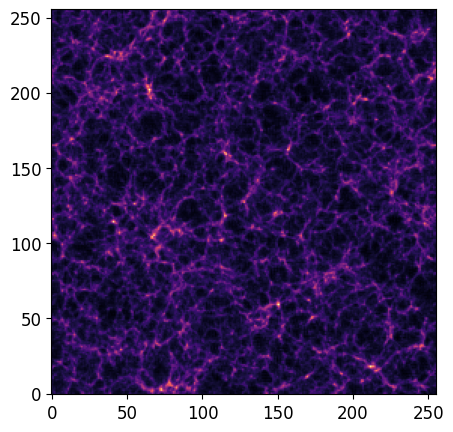

In [54]:
plt.figure(figsize=(12, 5))
plt.imshow(lpt_field[:16].sum(axis=0), origin='lower', cmap='magma')
plt.show()

# Spherical Painting

We convert a 3D particle distribution into a sky map by selecting a radial shell $[R_{\mathrm{min}}, R_{\mathrm{max}}]$ around the observer and “painting” each particle onto a HEALPix pixel. Different painters trade speed, noise, and small-scale fidelity.


## Method 1 — NGP (Nearest-Grid-Point)

Each particle deposits its full weight into the single nearest HEALPix pixel. No interpolation.

Fastest baseline; minimal memory and code complexity, but not differentiable and very noisy.

This basically uses a `healpy.ang2pix` implementation via the `jax_healpy` library (vectorized,differentiable and JAX-jittable).


In [55]:
# Method 1: NGP (Nearest Grid Point)
# Fast discrete assignment to nearest pixel - produces noisy but fast maps

start_time = time.time()
ngp_map = paint_particles_spherical(
    positions_default,
    method='ngp',
    nside=nside,
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape
).block_until_ready()
ngp_time = time.time() - start_time

print(f"NGP execution time: {ngp_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(ngp_map):.6f}")
print(f"  Max: {jnp.max(ngp_map):.6f}")
print(f"  Mean: {jnp.mean(ngp_map):.6f}")
print(f"  Non-zero pixels: {jnp.sum(ngp_map > 0)} / {len(ngp_map)}")
print(f"  Total mass: {jnp.sum(ngp_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(ngp_map))}")

NGP execution time: 0.2648 seconds
Map statistics:
  Min: 0.000000
  Max: 0.130068
  Mean: 0.016330
  Non-zero pixels: 776605 / 786432
  Total mass: 12842.210092
  All finite: True


## Method 2 — Bilinear Interpolation

Each particle spreads its weight over the local 4-pixel HEALPix stencil using `healpy.val_interp_weights` via `jax_healpy`. 

Smoother and differentiable maps with good mass conservation, **but** a bit slower than NGP and slightly smooths small scales.


In [56]:
# Method 2: Bilinear Interpolation  
# Smooth maps using 4-pixel interpolation stencil - good speed/quality balance

start_time = time.time()
bilinear_map = paint_particles_spherical(
    positions_default,
    method='bilinear',
    nside=nside,
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape
).block_until_ready()
bilinear_time = time.time() - start_time

print(f"Bilinear execution time: {bilinear_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(bilinear_map):.6f}")
print(f"  Max: {jnp.max(bilinear_map):.6f}")
print(f"  Mean: {jnp.mean(bilinear_map):.6f}")
print(f"  Non-zero pixels: {jnp.sum(bilinear_map > 0)} / {len(bilinear_map)}")
print(f"  Total mass: {jnp.sum(bilinear_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(bilinear_map))}")

Bilinear execution time: 1.7565 seconds
Map statistics:
  Min: 0.000023
  Max: 0.121370
  Mean: 0.016330
  Non-zero pixels: 786432 / 786432
  Total mass: 12842.210092
  All finite: True


## Method 3 — RBF Neighbors (Gaussian 9-pixel stencil)

Spreads each particle’s weight over a fixed 9-pixel patch (center + 8 neighbors) using a Gaussian kernel. Per-particle weights are renormalized so total mass is conserved; the fixed stencil keeps cost predictable.

**Kernel width**  
`kernel_width_arcmin` may be FWHM, $\sigma$, or $2\sigma$ (via `smoothing_interpretation`).  
By default, `kernel_width_arcmin=None` in this case we set $\sigma = \tfrac{1}{2}\,\text{pixel\_scale}$ at the chosen `nside` (using `jhp.nside2resol`). Larger widths smooth small scales more; smaller widths sharpen them (ensure $\sigma$ is not far below the pixel scale for stable normalization).

**Implementation notes**  
Uses `jax_healpy.vec2ang`, `get_all_neighbours`, and `pix2vec` which are vectorized, differentiable, and JAX-jittable.


In [57]:
# Method 3: RBF Neighbors
# Gaussian kernel smoothing using 9-pixel stencil - highest quality, slower execution

start_time = time.time()
rbf_map = paint_particles_spherical(
    positions_default,
    method='RBF_NEIGHBOR',
    nside=nside,
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape,
    kernel_width_arcmin=None,
).block_until_ready()
rbf_time = time.time() - start_time

print(f"RBF Neighbors execution time: {rbf_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(rbf_map):.6f}")
print(f"  Max: {jnp.max(rbf_map):.6f}")
print(f"  Mean: {jnp.mean(rbf_map):.6f}")
print(f"  Non-zero pixels: {jnp.sum(rbf_map > 0)} / {len(rbf_map)}")
print(f"  Total mass: {jnp.sum(rbf_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(rbf_map))}")

RBF Neighbors execution time: 4.8593 seconds
Map statistics:
  Min: 0.000235
  Max: 0.111916
  Mean: 0.016330
  Non-zero pixels: 786432 / 786432
  Total mass: 12842.210092
  All finite: True


## High-resolution painting + ud-grade (Methods 4–6)

These three variants paint at a higher resolution (`paint_nside`) and then downsample to the target `nside` with HEALPix `ud_grade` (via `jax_healpy`). 

This behaves like anti-aliasing: cleaner small scales for a small extra cost. We keep `ud_grade_power=0.0` here (treat values as **intensive**; average children). For truly **extensive** maps, pick the power/normalization that preserves totals.

### Method 4 — Bilinear + ud-grade
Paint with Bilinear at `paint_nside` and downsample. Smoother than direct Bilinear at `nside`, similar total mass, slightly higher runtime.

### Method 5 — RBF + ud-grade
Paint with RBF at `paint_nside` using your chosen kernel width, then downsample. Smoothest maps of the set; highest cost. Use kernel widths $\gtrsim$ pixel scale for stable normalization.

### Method 6 — NGP + ud-grade
Paint with NGP at `paint_nside`, then downsample. Much less aliasing than direct NGP while staying fast; still noisier than Bilinear-based options.


In [58]:
# Method 4: Bilinear + Udgrade
# Paint at high resolution, then downsample for improved smoothness

start_time = time.time()
udgrade_map = paint_particles_spherical(
    positions_default,
    nside=nside,  # Target resolution
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape,
    method="bilinear",
    paint_nside=paint_nside,  # Paint at higher resolution
    ud_grade_power=0.0
).block_until_ready()
udgrade_time = time.time() - start_time

print(f"Painting at nside={paint_nside}, downgrading to nside={nside}")
print(f"Udgrade execution time: {udgrade_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(udgrade_map):.6f}")
print(f"  Max: {jnp.max(udgrade_map):.6f}")
print(f"  Mean: {jnp.mean(udgrade_map):.6f}")
print(f"  Total mass: {jnp.sum(udgrade_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(udgrade_map))}")

# Compare with direct painting at target resolution
mass_ratio = jnp.sum(udgrade_map) / jnp.sum(bilinear_map)
print(f"Mass conservation (udgrade/direct): {mass_ratio:.6f}")
print(f"Smoothness difference (std): {jnp.std(udgrade_map):.6f} vs {jnp.std(bilinear_map):.6f}")

Painting at nside=512, downgrading to nside=256
Udgrade execution time: 1.9594 seconds
Map statistics:
  Min: 0.000000
  Max: 0.129422
  Mean: 0.016330
  Total mass: 12842.210092
  All finite: True
Mass conservation (udgrade/direct): 1.000000
Smoothness difference (std): 0.008090 vs 0.007354


In [59]:
# Method 5: RBF + Udgrade
# Combines RBF smoothness with udgrade flexibility

start_time = time.time()
rbf_udgrade_map = paint_particles_spherical(
    positions_default,
    nside=nside,  # Target resolution
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape,
    method="RBF_NEIGHBOR",
    paint_nside=paint_nside,  # Paint at higher resolution
    ud_grade_power=0.0
).block_until_ready()
rbf_udgrade_time = time.time() - start_time

print(f"RBF + Udgrade execution time: {rbf_udgrade_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(rbf_udgrade_map):.6f}")
print(f"  Max: {jnp.max(rbf_udgrade_map):.6f}")
print(f"  Mean: {jnp.mean(rbf_udgrade_map):.6f}")
print(f"  Total mass: {jnp.sum(rbf_udgrade_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(rbf_udgrade_map))}")

# Compare with direct RBF painting at target resolution
mass_ratio_rbf = jnp.sum(rbf_udgrade_map) / jnp.sum(rbf_map)
print(f"Mass conservation (rbf_udgrade/rbf_direct): {mass_ratio_rbf:.6f}")
print(f"Smoothness difference (std): {jnp.std(rbf_udgrade_map):.6f} vs {jnp.std(rbf_map):.6f}")

RBF + Udgrade execution time: 5.0737 seconds
Map statistics:
  Min: 0.000000
  Max: 0.131261
  Mean: 0.016330
  Total mass: 12842.210092
  All finite: True
Mass conservation (rbf_udgrade/rbf_direct): 1.000000
Smoothness difference (std): 0.009091 vs 0.006900


In [60]:
# Method 6: NGP + Udgrade  
# Combines NGP speed with udgrade smoothing - fastest udgrade option

start_time = time.time()
ngp_udgrade_map = paint_particles_spherical(
    positions_default,
    nside=nside,  # Target resolution
    observer_position=observer_position,
    R_min=R_min,
    R_max=R_max,
    box_size=box_size,
    mesh_shape=mesh_shape,
    method="NGP",
    paint_nside=paint_nside,  # Paint at higher resolution
    ud_grade_power=0.0
).block_until_ready()
ngp_udgrade_time = time.time() - start_time

print(f"NGP + Udgrade execution time: {ngp_udgrade_time:.4f} seconds")
print(f"Map statistics:")
print(f"  Min: {jnp.min(ngp_udgrade_map):.6f}")
print(f"  Max: {jnp.max(ngp_udgrade_map):.6f}")
print(f"  Mean: {jnp.mean(ngp_udgrade_map):.6f}")
print(f"  Total mass: {jnp.sum(ngp_udgrade_map):.6f}")
print(f"  All finite: {jnp.all(jnp.isfinite(ngp_udgrade_map))}")

# Compare with direct NGP painting at target resolution
mass_ratio_ngp = jnp.sum(ngp_udgrade_map) / jnp.sum(ngp_map)
print(f"Mass conservation (ngp_udgrade/ngp_direct): {mass_ratio_ngp:.6f}")
print(f"Smoothness difference (std): {jnp.std(ngp_udgrade_map):.6f} vs {jnp.std(ngp_map):.6f}")

NGP + Udgrade execution time: 0.5043 seconds
Map statistics:
  Min: 0.000000
  Max: 0.130068
  Mean: 0.016330
  Total mass: 12842.210092
  All finite: True
Mass conservation (ngp_udgrade/ngp_direct): 1.000000
Smoothness difference (std): 0.009113 vs 0.009113


## Performance summary

The code prints a table with runtime, speedup (relative to the fastest method), smoothness (std of the zero-mean map), and a mass-conservation check (total map mass vs. true shell count using the shell-volume normalization).

**What to take from it**
- **NGP** is the baseline fastest but also the noisiest (largest std) and not differentiable.
- **Bilinear** trades a small runtime increase for noticeably smoother maps; a solid default.
- **RBF neighbors** is smoothest and most stable for small-scale control, but it’s the slowest.
- **High-res + ud-grade (Methods 4–6)**: small overhead, modest smoothing gain; total mass remains $\approx 1$ when treated as an intensive field (with `ud_grade_power=0.0`).
- **RBF + ud-grade** effectively double-smooths (kernel + averaging); best visual smoothness, highest cost.


In [61]:
# Performance Summary
methods_data = {
    'NGP': {'time': ngp_time, 'map': ngp_map},
    'Bilinear': {'time': bilinear_time, 'map': bilinear_map},
    'RBF Neighbors': {'time': rbf_time, 'map': rbf_map},
    'NGP + Udgrade': {'time': ngp_udgrade_time, 'map': ngp_udgrade_map},
    'Bilinear + Udgrade': {'time': udgrade_time, 'map': udgrade_map},
    'RBF + Udgrade': {'time': rbf_udgrade_time, 'map': rbf_udgrade_map}
}

print("PERFORMANCE COMPARISON (All JAX-Accelerated)")
print("=" * 85)
print(f"{'Method':<20} {'Time (s)':<10} {'Speedup':<10} {'Smoothness':<12} {'Mass Conservation'}")
print("-" * 85)

baseline_time = min(data['time'] for data in methods_data.values())
# True mass in shell (unit weights)
true_mass = float(particles_in_shell)
# Pixel/shell volumes for physical mass conservation check
npix = jhp.nside2npix(nside)
pixel_area = 4 * jnp.pi / npix
shell_vol_per_pix = pixel_area * (R_max**3 - R_min**3) / 3.0

for method, data in methods_data.items():
    speedup = baseline_time / data['time']
    # Smoothness on zero-mean map
    m = data['map']
    smoothness = float(jnp.std(m - jnp.mean(m)))
    # Physical mass conservation: total_mass_map vs true_mass
    mass_map = float(jnp.sum(m) * shell_vol_per_pix)
    mass_conservation = mass_map / true_mass if true_mass > 0 else float('nan')
    print(f"{method:<20} {data['time']:<10.4f} {speedup:<10.2f}x {smoothness:<12.2e} {mass_conservation:.4f}")

PERFORMANCE COMPARISON (All JAX-Accelerated)
Method               Time (s)   Speedup    Smoothness   Mass Conservation
-------------------------------------------------------------------------------------
NGP                  0.2648     1.00      x 9.11e-03     1.0000
Bilinear             1.7565     0.15      x 7.35e-03     1.0000
RBF Neighbors        4.8593     0.05      x 6.90e-03     1.0000
NGP + Udgrade        0.5043     0.53      x 9.11e-03     1.0000
Bilinear + Udgrade   1.9594     0.14      x 8.09e-03     1.0000
RBF + Udgrade        5.0737     0.05      x 9.09e-03     1.0000


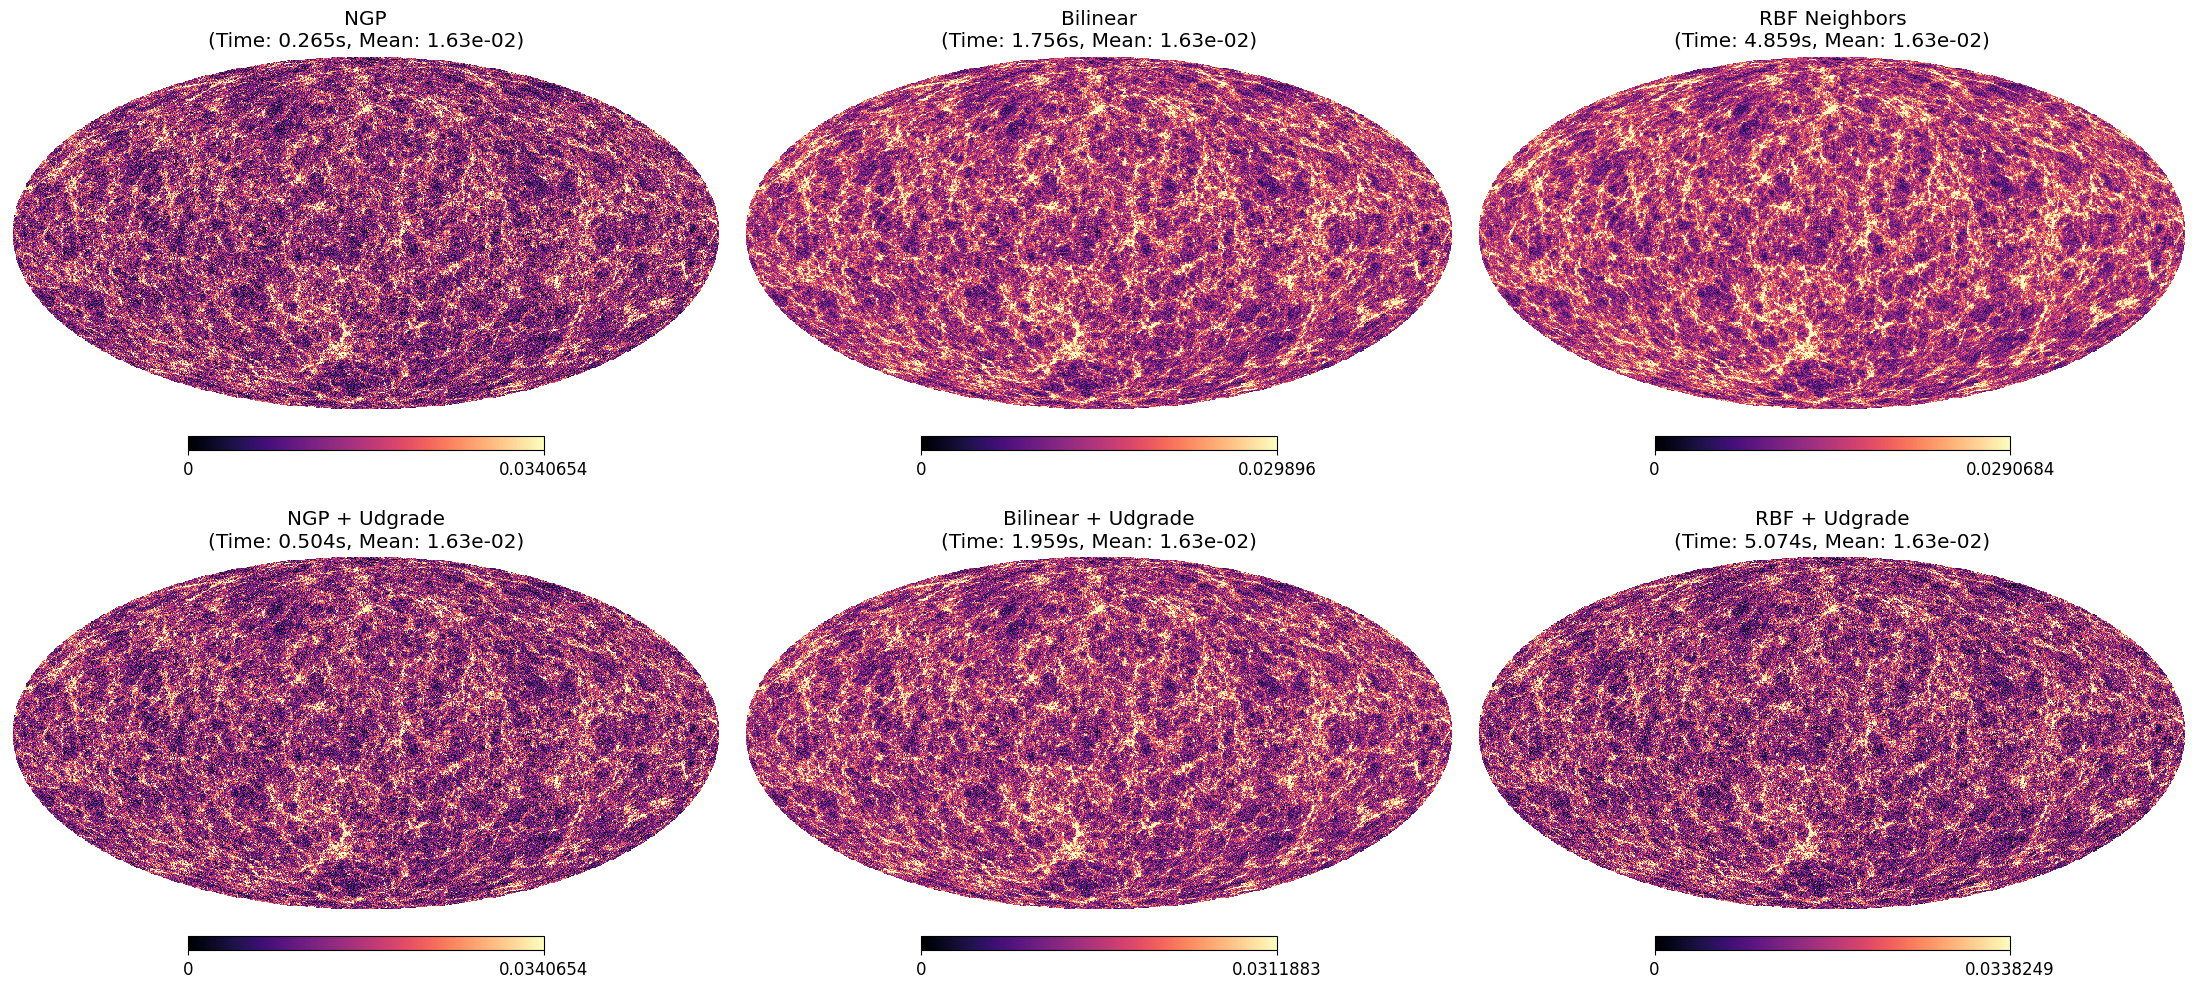

In [62]:
# Create visual comparison (6 methods + LPT field)
fig = plt.figure(figsize=(22, 10))

methods_list = ['NGP', 'Bilinear', 'RBF Neighbors', 'NGP + Udgrade', 'Bilinear + Udgrade', 'RBF + Udgrade']
maps_list = [ngp_map, bilinear_map, rbf_map, ngp_udgrade_map, udgrade_map, rbf_udgrade_map]
times_list = [ngp_time, bilinear_time, rbf_time, ngp_udgrade_time, udgrade_time, rbf_udgrade_time]

# Plot each method
nrows, ncols = 2, 3
for i, (method, map_data, exec_time) in enumerate(zip(methods_list, maps_list, times_list)):
    
    # Convert to numpy if needed
    map_np = np.array(map_data)
    
    # Create HEALPix mollweide projection
    hp.mollview(map_np, 
               title=f"{method}\n(Time: {exec_time:.3f}s, Mean: {np.mean(map_np):.2e})",
               cmap='magma', 
               sub=(nrows, ncols, i+1),
               cbar=True,
               min=0,
               max=np.percentile(map_np[map_np > 0], 95) if np.any(map_np > 0) else np.max(map_np))
    

plt.show()


## Power spectrum analysis

To assess painting accuracy we compare each method’s angular power spectrum $C_\ell$ to a theory curve computed with the Limber approximation (no lensing), using a **linear** matter power so it’s consistent with the LPT setup.


### Theory $C_\ell$ (Limber; linear, no lensing)

- Cosmology matches the simulation $(\Omega_c, \sigma_8)$.
- The shell $[R_{\mathrm{min}}, R_{\mathrm{max}}]$ is converted to a **top-hat** redshift window $p(z)$.
- Tracer model: unit linear bias ($b=1$), **no** RSD, **no** lensing.
- We evaluate $C_\ell$ for $\ell \ge 2$ (monopole/dipole excluded).

This gives a clean baseline that reflects the linear/LPT regime you simulated.


In [63]:
def compute_theory_cl():
    """Compute theoretical C_ell using Limber approximation (ℓ≥2)."""
    print("Computing theoretical C_ell with Limber approximation...")
    from jax.tree_util import register_pytree_node_class
    from jax_cosmo.redshift import redshift_distribution

    @register_pytree_node_class
    class tophat_z(redshift_distribution):
        def pz_fn(self, z):
            zmin, zmax = self.params
            return jnp.where((z >= zmin) & (z <= zmax), 1.0, 0.0)

    # Create cosmology (using same parameters as simulation)
    cosmo_th = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Convert comoving distances to redshifts for shell limits
    a_min = jc.background.a_of_chi(cosmo_th, R_min).squeeze()
    a_max = jc.background.a_of_chi(cosmo_th, R_max).squeeze()
    zmin = float(jc.utils.a2z(a_min))
    zmax = float(jc.utils.a2z(a_max))
    
    print(f"   Distance shell: [{R_min:.1f}, {R_max:.1f}] Mpc/h")
    print(f"   Redshift range: z ∈ [{zmin:.3f}, {zmax:.3f}]")
    
    # Top-hat redshift window and unit bias (galaxy clustering, no RSD)
    nz = tophat_z(zmin, zmax, gals_per_arcmin2=1.0)
    bias = jc.bias.constant_linear_bias(1.0)
    probe = jc.probes.NumberCounts([nz], bias, has_rsd=False)
    
    # Setup integration grid and compute C_ell
    ell_theory = jnp.arange(0, LMAX + 1)
    cl_theory = jc.angular_cl.angular_cl(cosmo_th, ell_theory, [probe], nonlinear_fn=jc.power.linear).squeeze()
    
    return np.array(ell_theory[2:]), np.array(cl_theory[2:])

# Compute theoretical power spectrum
ell_theory, cl_theory = compute_theory_cl()

print(f"Theoretical C_ℓ computed for ℓ ∈ [2, {LMAX}]")
print(f"Using cosmology: Ωc={omega_c}, σ8={sigma8}")
print(f"Top-hat redshift window for distance shell")

Computing theoretical C_ell with Limber approximation...
   Distance shell: [150.0, 400.0] Mpc/h
   Redshift range: z ∈ [0.051, 0.138]
Theoretical C_ℓ computed for ℓ ∈ [2, 768]
Using cosmology: Ωc=0.25, σ8=0.8
Top-hat redshift window for distance shell


### From maps to **overdensity** then to $C_\ell$

Directly comparing raw counts is misleading across methods, 

so we normalize each map to overdensity,
$\delta = \frac{\rho - \bar{\rho}}{\bar{\rho}}$.

We then compute auto-spectra with `healpy.anafast` up to $L_{\max} = 3\,\text{nside}$, dropping $\ell=0,1$.



In [64]:
# Organize results for analysis
print("ORGANIZING RESULTS FOR OVERDENSITY AND C_l ANALYSIS")
print("=" * 60)

# Create organized results dictionary
results = {}
for method, data in methods_data.items():
    density_map = data['map']
    mean_density = jnp.mean(density_map)
    
    # Compute overdensity: δ = (ρ - ρ̄)/ρ̄
    overdensity_map = jnp.where(mean_density > 0, (density_map - mean_density) / mean_density, 0.0)
    
    results[method] = {
        'raw_map': density_map,
        'overdensity_map': overdensity_map,
        'mean_density': float(mean_density),
        'time': data['time']
    }
    
    print(f"{method:20s}: mean_density = {float(mean_density):.6e}, δ_std = {float(jnp.std(overdensity_map)):.6f}")

print("Overdensity maps computed for all 6 methods")

ORGANIZING RESULTS FOR OVERDENSITY AND C_l ANALYSIS
NGP                 : mean_density = 1.632971e-02, δ_std = 0.558069
Bilinear            : mean_density = 1.632971e-02, δ_std = 0.450368
RBF Neighbors       : mean_density = 1.632971e-02, δ_std = 0.422543
NGP + Udgrade       : mean_density = 1.632971e-02, δ_std = 0.558069
Bilinear + Udgrade  : mean_density = 1.632971e-02, δ_std = 0.495394
RBF + Udgrade       : mean_density = 1.632971e-02, δ_std = 0.556694
Overdensity maps computed for all 6 methods


In [65]:

# Angular power spectra parameters
LMAX = 3 * nside  # Maximum multipole
print(f"Computing angular power spectra with LMAX = {LMAX}")
print("Using overdensity maps (ℓ≥2 only, dropping monopole and dipole)")
print()

def compute_power_spectra(results):
    """Compute auto C_ell for painted maps using overdensity (ℓ≥2)."""
    print("Computing angular power spectra (auto, overdensity_map)...")
    
    ell = np.arange(0, LMAX + 1)
    spectra_results = {}
    
    # Convert to numpy for healpy
    results_np = jax.tree.map(lambda x: np.array(x), results)
    
    for method_name in results_np.keys():
        print(f"   Computing {method_name}...")
        m = results_np[method_name]['overdensity_map']
        cl = hp.anafast(m, lmax=LMAX)
        
        spectra_results[method_name] = {
            'cl': cl[2:],  # Drop ℓ=0,1 (monopole, dipole)
            'ell': ell[2:]
        }
    
    return spectra_results

# Compute power spectra for all methods
spectra_results = compute_power_spectra(results)

# Display results summary
print("Angular power spectra computed for all methods")
print(f"Multipole range: ℓ ∈ [2, {LMAX}] ({len(spectra_results[list(spectra_results.keys())[0]]['ell'])} multipoles)")

# Show first few C_ell values for first method as example
first_method = list(spectra_results.keys())[0]
ell_sample = spectra_results[first_method]['ell'][:10]
cl_sample = spectra_results[first_method]['cl'][:10]

Computing angular power spectra with LMAX = 768
Using overdensity maps (ℓ≥2 only, dropping monopole and dipole)

Computing angular power spectra (auto, overdensity_map)...
   Computing Bilinear...
   Computing Bilinear + Udgrade...
   Computing NGP...
   Computing NGP + Udgrade...
   Computing RBF + Udgrade...
   Computing RBF Neighbors...
Angular power spectra computed for all methods
Multipole range: ℓ ∈ [2, 768] (767 multipoles)


### Pixel window correction ($W_\ell$)

HEALPix pixels have finite area, which smooths the map. The spectrum you get from `healpy.anafast` is therefore the **pixelized** auto-spectrum:
$$C_\ell^{\mathrm{obs}} \;\approx\; W_\ell^2 \; C_\ell^{\mathrm{true}}.$$

Here we compute the HEALPix pixel window $W_\ell$ for the target `nside` with `hp.pixwin`, slice to $\ell\ge2$, and apply the factor to the **theory** curve:
$$C_\ell^{\mathrm{theory,\,corr}} \;=\; W_\ell^2 \, C_\ell^{\mathrm{theory}}.$$

This way, we compare “like with like”: theory-after-pixelization vs. the `anafast` output from the pixelized maps. (Equivalently, you could divide the measured $C_\ell$ by $W_\ell^2$, but multiplying the theory avoids noisy deconvolution.)


In [17]:
def compute_pixel_window(nside_val, lmax_val):
    """Return HEALPix pixel window W_ell up to lmax, sliced to ell>=2.
    
    For auto-spectra, observed Cl ≈ W_ell^2 × true Cl.
    """
    w = hp.pixwin(nside_val, lmax=lmax_val)
    return np.asarray(w[2:])

def compute_corrections():
    """Compute HEALPix pixel window W_ell for nside, sliced to ℓ≥2."""
    print("Computing pixel window correction...")
    w_ell = compute_pixel_window(nside, LMAX)
    return {'pixel_window': w_ell}

# Compute corrections
corrections = compute_corrections()
w_ell = corrections['pixel_window']

# Apply pixel window correction to theory (auto-spectrum: W_ell^2)
cl_theory_corrected = cl_theory * (w_ell**2)

print(f"Pixel window function computed for nside={nside}")
print(f"Applied W_ℓ² correction for auto-spectra")
print(f"Correction range: ℓ ∈ [2, {LMAX}] ({len(w_ell)} multipoles)")

Computing pixel window correction...
Pixel window function computed for nside=256
Applied W_ℓ² correction for auto-spectra
Correction range: ℓ ∈ [2, 768] (767 multipoles)


## Comparing painted **overdensity** maps to theory at the power-spectrum level

We compare each method’s $C_\ell$ (from overdensity maps via `anafast`) to a Limber $C_\ell$ built with the same cosmology and a top-hat shell. For apples-to-apples, we also show the **pixel-window**–corrected theory $C_\ell \times W_\ell^2$.

**What to look for**
- **Small-scale behavior:** curves rising above theory at high $\ell$ indicate extra small-scale power (less smoothing).
- **Pixelization:** data should sit closer to the **corrected** theory at large $\ell$, where $W_\ell$ matters most.

**Observations**
- **High-res paint + ud-grade (Methods 4–6)** adds small-scale power: painting at higher `paint_nside` captures sub-pixel structure that survives downsampling, so spectra lie above direct-`nside` results at large $\ell$.
- **RBF (default kernel)** tends to track the **uncorrected** theory at intermediate $\ell$: the default $\sigma \approx$ half a pixel roughly offsets pixel smoothing. Increasing the kernel width damps high-$\ell$ toward the pixel-window–corrected curve.


Creating with/without pixel-window comparison plot...


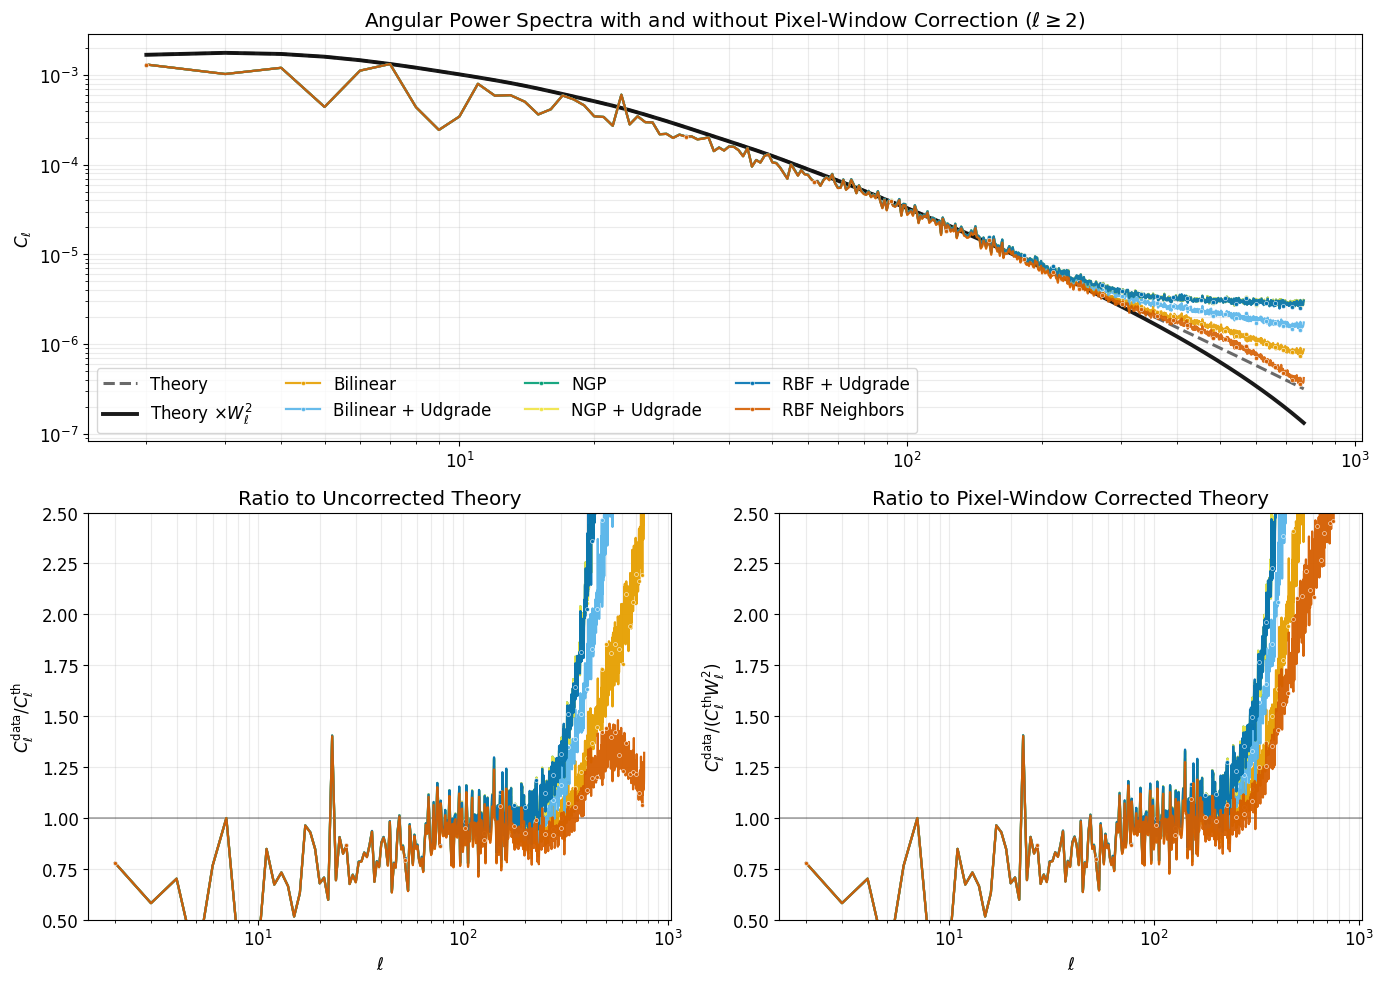

In [78]:
def plot_compare_corrections(spectra_results, ell_th, cl_th, corrections):
    """Compare data against theory with and without pixel-window.

    Improves readability with a colorblind-safe palette, thicker theory lines,
    reduced marker density, and separated legends.
    """
    print("Creating with/without pixel-window comparison plot...")

    # Prepare theory curves
    w = corrections['pixel_window']
    cl_th_corr = cl_th * (w**2)

    # Colorblind-safe palette (Okabe–Ito)
    palette = ["#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7","#000000"]
    method_names = list(spectra_results.keys())
    num_methods = len(method_names)

    # Figure / axes
    fig = plt.figure(figsize=(14, 10))
    ax_main = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax_ratio_unc = plt.subplot2grid((2, 2), (1, 0))
    ax_ratio_cor = plt.subplot2grid((2, 2), (1, 1), sharex=ax_ratio_unc)

    # --- Top: spectra with both theory curves (make theory very visible)
    ax_main.loglog(ell_th, cl_th, color="0.35", linestyle="--", linewidth=2.2,
                   alpha=0.9, label="Theory")
    ax_main.loglog(ell_th, cl_th_corr, color="0.05", linestyle="-", linewidth=2.8,
                   alpha=0.95, label=r"Theory $\times W_\ell^2$")

    # Methods: use solid lines, tiny semi-transparent markers every ~25 points
    for i, method_name in enumerate(method_names):
        ell = spectra_results[method_name]['ell']
        cl = spectra_results[method_name]['cl']
        # Reduce visual clutter: draw fewer markers
        step = max(1, len(ell) // 25)
        color = palette[i % len(palette)]
        ax_main.loglog(
            ell, cl,
            color=color, linewidth=1.6, alpha=0.9,
            marker='o', markersize=3, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
            label=method_name
        )

    ax_main.set_ylabel(r"$C_\ell$")
    ax_main.set_title("Angular Power Spectra with and without Pixel-Window Correction ($\ell\geq2$)")
    ax_main.grid(True, alpha=0.25, which="both")
    # Put legend in two lines above the plot to avoid overlap
    ax_main.legend(ncol=4)

    # --- Bottom-left: ratios to uncorrected theory
    ax_ratio_unc.axhline(1.0, color='black', linestyle='-', alpha=0.35, linewidth=1.2)
    for i, method_name in enumerate(method_names):
        ell = spectra_results[method_name]['ell']
        cl = spectra_results[method_name]['cl']
        m = min(len(ell_th), len(ell))
        ratio = cl[:m] / cl_th[:m]
        color = palette[i % len(palette)]
        step = max(1, m // 30)
        ax_ratio_unc.semilogx(
            ell[:m], ratio,
            color=color, linewidth=1.6, alpha=0.95,
            marker='o', markersize=2.8, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
            label=method_name
        )
    ax_ratio_unc.set_xlabel(r"$\ell$")
    ax_ratio_unc.set_ylabel(r"$C_\ell^{\mathrm{data}} / C_\ell^{\mathrm{th}}$")
    ax_ratio_unc.set_title("Ratio to Uncorrected Theory")
    ax_ratio_unc.grid(True, alpha=0.25, which="both")
    ax_ratio_unc.set_ylim(0.5, 2.5)

    # --- Bottom-right: ratios to corrected theory
    ax_ratio_cor.axhline(1.0, color='black', linestyle='-', alpha=0.35, linewidth=1.2)
    for i, method_name in enumerate(method_names):
        ell = spectra_results[method_name]['ell']
        cl = spectra_results[method_name]['cl']
        m = min(len(ell_th), len(ell))
        ratio = cl[:m] / cl_th_corr[:m]
        color = palette[i % len(palette)]
        step = max(1, m // 30)
        ax_ratio_cor.semilogx(
            ell[:m], ratio,
            color=color, linewidth=1.6, alpha=0.95,
            marker='o', markersize=2.8, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
        )
    ax_ratio_cor.set_xlabel(r"$\ell$")
    ax_ratio_cor.set_ylabel(r"$C_\ell^{\mathrm{data}} / (C_\ell^{\mathrm{th}} W_\ell^2)$")
    ax_ratio_cor.set_title("Ratio to Pixel-Window Corrected Theory")
    ax_ratio_cor.grid(True, alpha=0.25, which="both")
    ax_ratio_cor.set_ylim(0.5, 2.5)

    plt.tight_layout()
    plt.show()

# Create the with/without correction comparison
plot_compare_corrections(spectra_results, ell_theory, cl_theory, corrections)


## RBF Smoothing Scale Analysis

The RBF method includes a `smoothing_scale` parameter that controls the Gaussian kernel width. 

This section demonstrates the effect of different smoothing scales on map quality and power spectra. We test three smoothing scales: default, 1.0,15.0 and 20.0 arcminutes.

In [81]:
# Test different RBF smoothing scales
kernel_widths_arcmin = [None , 0.1, 15.0, 20.0]  # arcminutes
rbf_smoothing_results = {}

print("Testing RBF method with different smoothing scales...")
print("=" * 60)

for kernel_width_arcmin in kernel_widths_arcmin:
    print(f"Computing RBF with kernel width = {kernel_width_arcmin} arcmin...")
    
    start_time = time.time()
    rbf_map_smooth = paint_particles_spherical(
        positions_default,
        method='RBF_NEIGHBOR',
        nside=nside,
        observer_position=observer_position,
        R_min=R_min,
        R_max=R_max,
        box_size=box_size,
        mesh_shape=mesh_shape,
        kernel_width_arcmin=kernel_width_arcmin
    ).block_until_ready()
    exec_time = time.time() - start_time
    
    # Store results
    rbf_smoothing_results[f'RBF (σ={kernel_width_arcmin}\')'] = {
        'map': rbf_map_smooth,
        'time': exec_time,
        'kernel_width_arcmin': kernel_width_arcmin
    }
    
    print(f"  Execution time: {exec_time:.4f} seconds")
    print(f"  Map statistics:")
    print(f"    Mean: {jnp.mean(rbf_map_smooth):.6f}")
    print(f"    Std: {jnp.std(rbf_map_smooth):.6f}")
    print(f"    Total mass: {jnp.sum(rbf_map_smooth):.6f}")
    print(f"    All finite: {jnp.all(jnp.isfinite(rbf_map_smooth))}")
    print()

print("RBF smoothing scale analysis completed")

Testing RBF method with different smoothing scales...
Computing RBF with kernel width = None arcmin...
  Execution time: 4.6349 seconds
  Map statistics:
    Mean: 0.016330
    Std: 0.006900
    Total mass: 12842.210092
    All finite: True

Computing RBF with kernel width = 0.1 arcmin...
  Execution time: 4.6346 seconds
  Map statistics:
    Mean: 0.000695
    Std: 0.001490
    Total mass: 546.808520
    All finite: True

Computing RBF with kernel width = 15.0 arcmin...
  Execution time: 4.7452 seconds
  Map statistics:
    Mean: 0.016330
    Std: 0.007083
    Total mass: 12842.210092
    All finite: True

Computing RBF with kernel width = 20.0 arcmin...
  Execution time: 4.7284 seconds
  Map statistics:
    Mean: 0.016330
    Std: 0.006488
    Total mass: 12842.210092
    All finite: True

RBF smoothing scale analysis completed


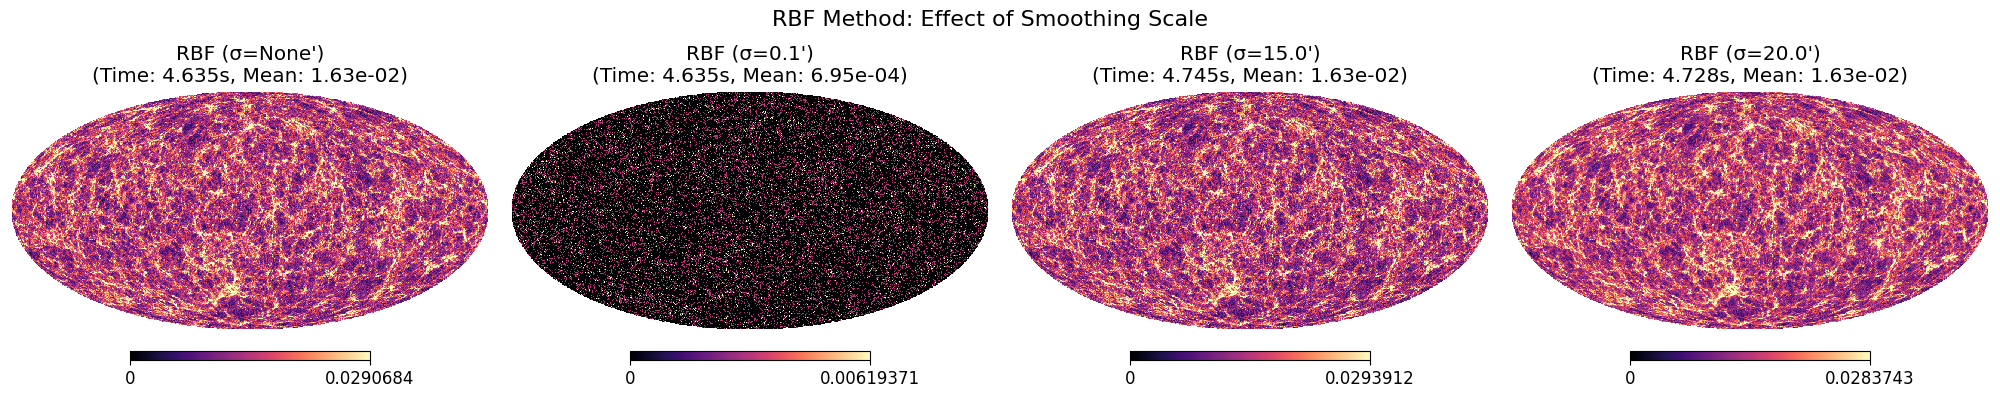

\nRBF SMOOTHING SCALE PERFORMANCE COMPARISON
Method          Scale (arcmin)  Time (s)   Smoothness  
------------------------------------------------------------
RBF (σ=None')   None 4.6349     6.90e-03    
RBF (σ=0.1')    0.1 4.6346     1.49e-03    
RBF (σ=15.0')   15.0 4.7452     7.08e-03    
RBF (σ=20.0')   20.0 4.7284     6.49e-03    


In [84]:
# Visual comparison of RBF smoothing scales
fig = plt.figure(figsize=(20, 4))

method_names = list(rbf_smoothing_results.keys())
maps_list = [rbf_smoothing_results[method]['map'] for method in method_names]
times_list = [rbf_smoothing_results[method]['time'] for method in method_names]
num_methods = len(method_names)
# Plot each smoothing scale
for i, (method, map_data, exec_time) in enumerate(zip(method_names, maps_list, times_list)):
    
    # Convert to numpy if needed
    map_np = np.array(map_data)
    
    # Create HEALPix mollweide projection
    hp.mollview(map_np, 
               title=f"{method}\n(Time: {exec_time:.3f}s, Mean: {np.mean(map_np):.2e})",
               cmap='magma', 
               sub=(1, num_methods, i+1),
               cbar=True,
               min=0,
               max=np.percentile(map_np[map_np > 0], 95) if np.any(map_np > 0) else np.max(map_np))
    
plt.suptitle('RBF Method: Effect of Smoothing Scale', fontsize=16, y=0.95)
plt.show()

# Performance comparison for smoothing scales
print("\\nRBF SMOOTHING SCALE PERFORMANCE COMPARISON")
print("=" * 60)
print(f"{'Method':<15} {'Scale (arcmin)':<15} {'Time (s)':<10} {'Smoothness':<12}")
print("-" * 60)

for method, data in rbf_smoothing_results.items():
    m = data['map']
    smoothness = float(jnp.std(m - jnp.mean(m)))
    scale = data['kernel_width_arcmin']
    print(f"{method:<15} {scale} {data['time']:<10.4f} {smoothness:<12.2e}")

### RBF Smoothing: Angular Power Spectrum Analysis

We now perform the same comprehensive power spectrum analysis for the RBF smoothing variants to quantify how different smoothing scales affect the angular power spectra.

In [38]:
# Organize RBF smoothing results for power spectrum analysis
print("ORGANIZING RBF SMOOTHING RESULTS FOR POWER SPECTRUM ANALYSIS")
print("=" * 70)

rbf_smoothing_ps_results = {}
for method, data in rbf_smoothing_results.items():
    density_map = data['map']
    mean_density = jnp.mean(density_map)
    
    # Compute overdensity: δ = (ρ - ρ̄)/ρ̄
    overdensity_map = jnp.where(mean_density > 0, (density_map - mean_density) / mean_density, 0.0)
    
    rbf_smoothing_ps_results[method] = {
        'raw_map': density_map,
        'overdensity_map': overdensity_map,
        'mean_density': float(mean_density),
        'time': data['time'],
        'kernel_width_arcmin': data['kernel_width_arcmin']
    }
    
    print(f"{method:15s}: mean_density = {float(mean_density):.6e}, δ_std = {float(jnp.std(overdensity_map)):.6f}")

print("Overdensity maps computed for all RBF smoothing variants")

ORGANIZING RBF SMOOTHING RESULTS FOR POWER SPECTRUM ANALYSIS
RBF (σ=None')  : mean_density = 1.632971e-02, δ_std = 0.422543
RBF (σ=0.1')   : mean_density = 6.953030e-04, δ_std = 2.143182
RBF (σ=15.0')  : mean_density = 1.632971e-02, δ_std = 0.433734
RBF (σ=20.0')  : mean_density = 1.632971e-02, δ_std = 0.397333
Overdensity maps computed for all RBF smoothing variants


In [39]:
# Compute power spectra for RBF smoothing variants
print("Computing angular power spectra for RBF smoothing variants...")

rbf_smoothing_spectra = {}
# Convert to numpy for healpy
rbf_results_np = jax.tree.map(lambda x: np.array(x), rbf_smoothing_ps_results)

for method_name in rbf_results_np.keys():
    print(f"   Computing {method_name}...")
    m = rbf_results_np[method_name]['overdensity_map']
    cl = hp.anafast(m, lmax=LMAX)
    
    rbf_smoothing_spectra[method_name] = {
        'cl': cl[2:],  # Drop ℓ=0,1 (monopole, dipole)
        'ell': np.arange(2, LMAX + 1)
    }

print(f"Angular power spectra computed for all RBF smoothing variants")
print(f"Multipole range: ℓ ∈ [2, {LMAX}] ({len(rbf_smoothing_spectra[list(rbf_smoothing_spectra.keys())[0]]['ell'])} multipoles)")

Computing angular power spectra for RBF smoothing variants...
   Computing RBF (σ=0.1')...
   Computing RBF (σ=15.0')...
   Computing RBF (σ=20.0')...
   Computing RBF (σ=None')...
Angular power spectra computed for all RBF smoothing variants
Multipole range: ℓ ∈ [2, 768] (767 multipoles)


### RBF kernel width: impact on $C_\ell$

Increasing the kernel width damps small-scale power: larger $\sigma$ pushes the curves **down** at high $\ell$, moving them toward the pixel-window–corrected theory $C_\ell \times W_\ell^2$.

**Key points**
- **Small $\sigma$ (e.g., $0.1'$):** minimal smoothing → excess high-$\ell$ power; can even overshoot the theory. If $\sigma \ll$ pixel size, normalization can become fragile.
- **Default ($\sigma \approx$ half-pixel):** balances smoothing and fidelity; tends to track the **uncorrected** theory at intermediate $\ell$.
- **Sufficiently large $\sigma$ (e.g., $15'$–$20'$ at nside=256):** strong high-$\ell$ damping; spectra align closely with $C_\ell^{\text{theory}} W_\ell^2$.

Because the method uses a fixed 9-pixel stencil, runtime changes little with $\sigma$—you mostly trade small-scale power for smoothness.


Creating RBF smoothing power spectra comparison plot...


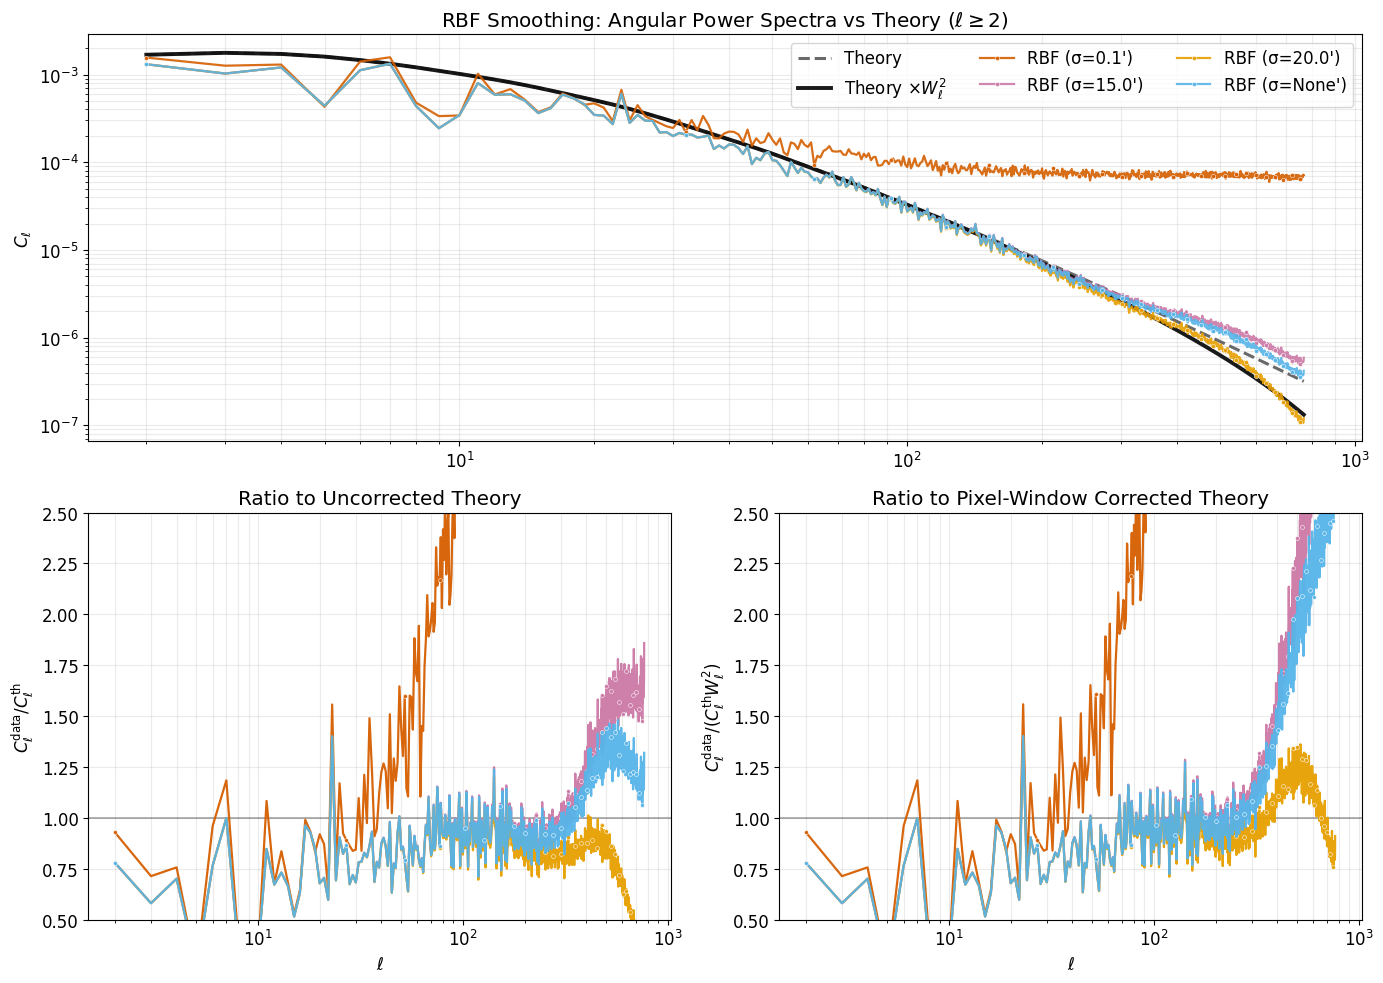

In [83]:
# Plot RBF smoothing power spectra comparison
def plot_rbf_smoothing_comparison(rbf_spectra, ell_th, cl_th, cl_th_corr):
    """Compare RBF smoothing variants against theory, styled like the main comparison."""
    print("Creating RBF smoothing power spectra comparison plot...")

    # Colorblind-safe palette (Okabe–Ito) — pick distinct colors for 4 curves
    palette = ["#D55E00", "#CC79A7", "#E69F00", "#56B4E9"]
    method_names = list(rbf_spectra.keys())

    # Figure / axes (same grid)
    fig = plt.figure(figsize=(14, 10))
    ax_main = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax_ratio_unc = plt.subplot2grid((2, 2), (1, 0))
    ax_ratio_cor = plt.subplot2grid((2, 2), (1, 1), sharex=ax_ratio_unc)

    # --- Top: spectra with both theory curves (thicker, very visible)
    ax_main.loglog(ell_th, cl_th, color="0.35", linestyle="--", linewidth=2.2,
                   alpha=0.9, label="Theory")
    ax_main.loglog(ell_th, cl_th_corr, color="0.05", linestyle="-", linewidth=2.8,
                   alpha=0.95, label=r"Theory $\times W_\ell^2$")

    # RBF variants: solid lines + sparse markers
    for i, method_name in enumerate(method_names):
        ell = rbf_spectra[method_name]['ell']
        cl = rbf_spectra[method_name]['cl']
        step = max(1, len(ell) // 25)
        color = palette[i % len(palette)]
        ax_main.loglog(
            ell, cl,
            color=color, linewidth=1.6, alpha=0.9,
            marker='o', markersize=3, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
            label=method_name
        )

    ax_main.set_ylabel(r"$C_\ell$")
    ax_main.set_title("RBF Smoothing: Angular Power Spectra vs Theory ($\\ell\\geq 2$)")
    ax_main.grid(True, alpha=0.25, which="both")
    ax_main.legend(ncol=3)

    # --- Bottom-left: ratios to uncorrected theory
    ax_ratio_unc.axhline(1.0, color='black', linestyle='-', alpha=0.35, linewidth=1.2)
    for i, method_name in enumerate(method_names):
        ell = rbf_spectra[method_name]['ell']
        cl = rbf_spectra[method_name]['cl']
        m = min(len(ell_th), len(ell))
        ratio = cl[:m] / cl_th[:m]
        color = palette[i % len(palette)]
        step = max(1, m // 30)
        ax_ratio_unc.semilogx(
            ell[:m], ratio,
            color=color, linewidth=1.6, alpha=0.95,
            marker='o', markersize=2.8, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
            label=method_name
        )
    ax_ratio_unc.set_xlabel(r"$\ell$")
    ax_ratio_unc.set_ylabel(r"$C_\ell^{\mathrm{data}} / C_\ell^{\mathrm{th}}$")
    ax_ratio_unc.set_title("Ratio to Uncorrected Theory")
    ax_ratio_unc.grid(True, alpha=0.25, which="both")
    ax_ratio_unc.set_ylim(0.5, 2.5)

    # --- Bottom-right: ratios to corrected theory
    ax_ratio_cor.axhline(1.0, color='black', linestyle='-', alpha=0.35, linewidth=1.2)
    for i, method_name in enumerate(method_names):
        ell = rbf_spectra[method_name]['ell']
        cl = rbf_spectra[method_name]['cl']
        m = min(len(ell_th), len(ell))
        ratio = cl[:m] / cl_th_corr[:m]
        color = palette[i % len(palette)]
        step = max(1, m // 30)
        ax_ratio_cor.semilogx(
            ell[:m], ratio,
            color=color, linewidth=1.6, alpha=0.95,
            marker='o', markersize=2.8, markevery=step,
            markerfacecolor=color, markeredgecolor="white", markeredgewidth=0.4,
        )
    ax_ratio_cor.set_xlabel(r"$\ell$")
    ax_ratio_cor.set_ylabel(r"$C_\ell^{\mathrm{data}} / (C_\ell^{\mathrm{th}} W_\ell^2)$")
    ax_ratio_cor.set_title("Ratio to Pixel-Window Corrected Theory")
    ax_ratio_cor.grid(True, alpha=0.25, which="both")
    ax_ratio_cor.set_ylim(0.5, 2.5)

    plt.tight_layout()
    plt.show()

# Example call (you already have cl_theory_corrected):
plot_rbf_smoothing_comparison(rbf_smoothing_spectra, ell_theory, cl_theory, cl_theory_corrected)
